In [2]:
import pandas as pd 
import numpy as np
from sklearn.preprocessing import LabelEncoder
from sklearn.ensemble import RandomForestClassifier
from sklearn.feature_selection import SelectKBest, chi2
from sklearn.preprocessing import MinMaxScaler
from sklearn.feature_selection import RFE
import seaborn as sns
import matplotlib.pyplot as plt
from imblearn.over_sampling import SMOTE
from scipy.stats import skew
from sklearn.preprocessing import PowerTransformer
from sklearn.model_selection import train_test_split
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import accuracy_score, classification_report
from sklearn.svm import SVC
from xgboost import XGBClassifier
from sklearn.metrics import confusion_matrix
import torch
import torch.nn as nn
import torch.optim as optim
import torch.nn.functional as F
from torch.utils.data import DataLoader, TensorDataset


In [3]:
main = pd.read_csv("/kaggle/input/info-sec-dataset/infosec_all/malicious_phish.csv")
main

,url,type
0,br-icloud.com.br,phishing
1,mp3raid.com/music/krizz_kaliko.html,benign
2,bopsecrets.org/rexroth/cr/1.htm,benign
3,http://www.garage-pirenne.be/index.php?option=...,defacement
4,http://adventure-nicaragua.net/index.php?optio...,defacement
...,...,...
651186,xbox360.ign.com/objects/850/850402.html,phishing
651187,games.teamxbox.com/xbox-360/1860/Dead-Space/,phishing
651188,www.gamespot.com/xbox360/action/deadspace/,phishing
651189,en.wikipedia.org/wiki/Dead_Space_(video_game),phishing


# Merging Datasets

In [4]:

# Define a list of file paths and corresponding types
file_paths = [
    ("/kaggle/input/info-sec-dataset/info_sec_final_dataset/FinalDataset/URL/Benign_list_big_final.csv", "benign"),
    ("/kaggle/input/info-sec-dataset/info_sec_final_dataset/FinalDataset/URL/DefacementSitesURLFiltered.csv", "defacement"),
    ("/kaggle/input/info-sec-dataset/info_sec_final_dataset/FinalDataset/URL/Malware_dataset.csv", "malware"),
    ("/kaggle/input/info-sec-dataset/info_sec_final_dataset/FinalDataset/URL/phishing_dataset.csv", "phishing"),
    ("/kaggle/input/info-sec-dataset/info_sec_final_dataset/FinalDataset/URL/spam_dataset.csv", "spam")
]

# Initialize an empty list to store dataframes
dfs = []

# Iterate through the file paths and types
for file_path, url_type in file_paths:
    # Read the CSV file
    df = pd.read_csv(file_path, header=None)
    # Assign column names
    df.columns = ["url"]
    # Add a column for the URL type
    df["type"] = url_type
    # Append the dataframe to the list
    dfs.append(df)

dfs.append(main)
# Concatenate the list of dataframes into a single dataframe
new = pd.concat(dfs, ignore_index=True)
new.drop_duplicates(inplace=True)
new.reset_index(drop=True, inplace=True)

# Display the merged dataframe
new

,url,type
0,http://1337x.to/torrent/1048648/American-Snipe...,benign
1,http://1337x.to/torrent/1110018/Blackhat-2015-...,benign
2,http://1337x.to/torrent/1122940/Blackhat-2015-...,benign
3,http://1337x.to/torrent/1124395/Fast-and-Furio...,benign
4,http://1337x.to/torrent/1145504/Avengers-Age-o...,benign
...,...,...
653041,xbox360.ign.com/objects/850/850402.html,phishing
653042,games.teamxbox.com/xbox-360/1860/Dead-Space/,phishing
653043,www.gamespot.com/xbox360/action/deadspace/,phishing
653044,en.wikipedia.org/wiki/Dead_Space_(video_game),phishing


# Extracting Features

In [5]:
import re
from urllib.parse import urlparse
from datetime import datetime


SUSPICIOUS_WORDS = ["login", "secure", "bank", "verify", "update", "confirm", "account"]

def extract_url_features(url):
    try:
        parsed_url = urlparse(url)
        domain = parsed_url.netloc
        path = parsed_url.path
        query = parsed_url.query
        
        # Extract Features
        features = {
            "url_length": len(url),
            "domain_length": len(domain),
            "num_digits": sum(c.isdigit() for c in url),
            "num_special_chars": len(re.findall(r'[@_\-=%&]', url)),
            "num_subdomains": domain.count('.'),
            "https": int(url.startswith("https")),
            "is_shortened": int(domain in ["bit.ly", "tinyurl.com", "goo.gl", "t.co"]),
            "url_depth": path.count('/'),
            "num_params": query.count('&') + (1 if query else 0),
            "suspicious_keywords": int(any(word in path.lower() for word in SUSPICIOUS_WORDS))
        }
        return features
    except:
        return None 

new_features = new["url"].apply(lambda url: extract_url_features(url))
features_df = pd.DataFrame(new_features.tolist())  # Convert list of dicts to DataFrame

new = pd.concat([new, features_df], axis=1)

In [6]:
!pip install tldextract


   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 104.9/104.9 kB 4.0 MB/s eta 0:00:00


In [7]:
import tldextract  
def extract_tld(url):
    extracted = tldextract.extract(url) 
    return extracted.suffix  

new["tld"] = new["url"].apply(extract_tld)  

In [8]:
backup_url = new['url']
del new['url']


# Pre-processing

In [9]:
features = new.drop(columns=new.columns[0]) 

In [10]:
numeric_cols = features.select_dtypes(include=['number']).columns
features.replace([np.inf, -np.inf], np.nan, inplace=True)
features[numeric_cols] = features[numeric_cols].fillna(features[numeric_cols].mean())

In [11]:
from sklearn.preprocessing import LabelEncoder

label_encoder = LabelEncoder()

new["type"] = label_encoder.fit_transform(new["type"])
classes = new["type"]
dict(enumerate(label_encoder.classes_))

{0: 'benign', 1: 'defacement', 2: 'malware', 3: 'phishing', 4: 'spam'}

In [12]:
X = new.drop(columns=new.columns[0]) 
y = new['type']

In [13]:
X

,url_length,domain_length,num_digits,num_special_chars,num_subdomains,https,is_shortened,url_depth,num_params,suspicious_keywords,tld
0,83,8,18,8,1,0,0,4,0,0,to
1,83,8,23,9,1,0,0,4,0,0,to
2,83,8,22,9,1,0,0,4,0,0,to
3,83,8,18,11,1,0,0,4,0,0,to
4,83,8,18,9,1,0,0,4,0,0,to
...,...,...,...,...,...,...,...,...,...,...,...
653041,39,0,12,0,0,0,0,3,0,0,com
653042,44,0,7,2,0,0,0,4,0,0,com
653043,42,0,3,0,0,0,0,4,0,0,com
653044,45,0,0,3,0,0,0,2,0,0,org


## Applying SMOTE to balance dataset

In [14]:
from imblearn.over_sampling import SMOTE
from gensim.models import Word2Vec
import numpy as np

tld_list = X['tld'].astype(str).tolist()  # Convert to list
w2v_model = Word2Vec(sentences=[tld_list], vector_size=10, min_count=1, window=3, workers=4)

tld_embeddings = np.array([w2v_model.wv[tld] for tld in tld_list])

X_numeric = X.drop(columns=['tld'])  
X_final = np.hstack((X_numeric, tld_embeddings))  # Add embeddings

smote = SMOTE(sampling_strategy='auto', random_state=42)
X_resampled, y_resampled = smote.fit_resample(X_final, y)

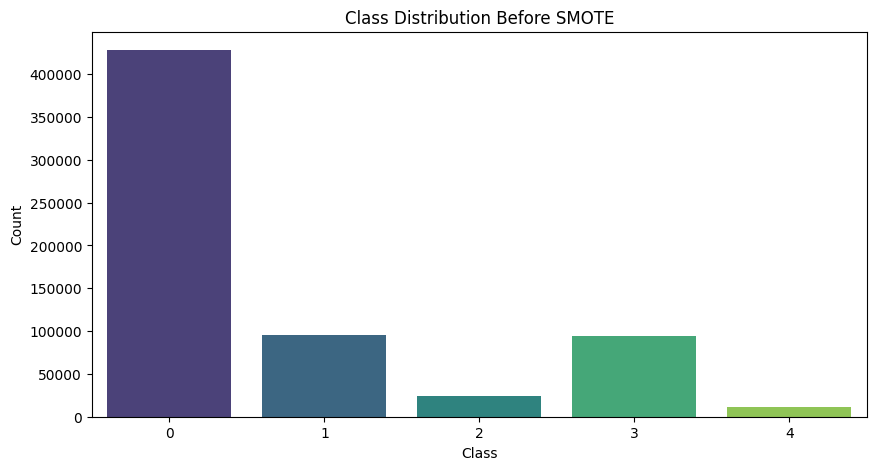

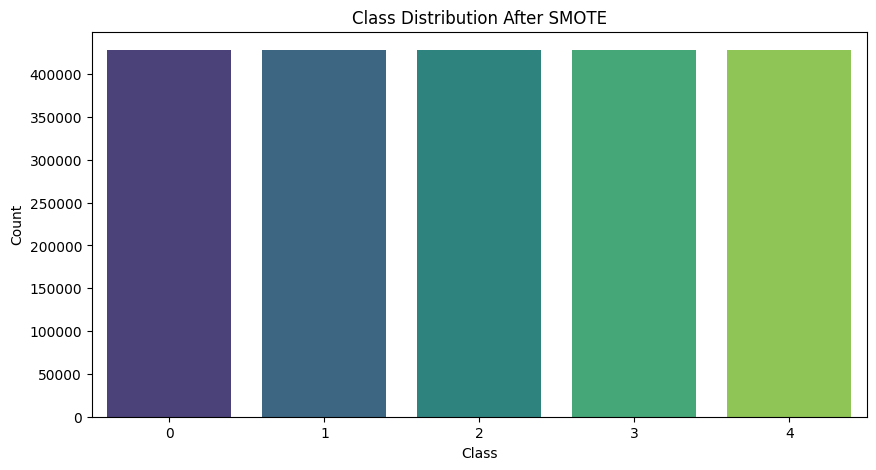

In [72]:
plt.figure(figsize=(10, 5))
sns.countplot(x=y, palette="viridis")
plt.title("Class Distribution Before SMOTE")
plt.xlabel("Class")
plt.ylabel("Count")
plt.show()

# After SMOTE
plt.figure(figsize=(10, 5))
sns.countplot(x=y_resampled, palette="viridis")
plt.title("Class Distribution After SMOTE")
plt.xlabel("Class")
plt.ylabel("Count")
plt.show()

# Selecting Useful Features

## Random Forest

In [15]:
X = X.drop(columns=['tld'])
original_feature_names = X.columns.tolist()


embedding_feature_names = [f'TLD_emb_{i}' for i in range(tld_embeddings.shape[1])]

all_feature_names = original_feature_names + embedding_feature_names

X_resampled_df = pd.DataFrame(X_resampled, columns=all_feature_names)

rf = RandomForestClassifier(n_estimators=100, random_state=42)
rf.fit(X_resampled_df, y_resampled)

importances = rf.feature_importances_

importance_df = pd.DataFrame({'Feature': all_feature_names, 'Importance': importances})

importance_df = importance_df.sort_values(by="Importance", ascending=False)

top_features = importance_df.head(10)['Feature'].tolist()

# Keep only these top 10 features in X_resampled
X_resampled_selected = X_resampled_df[top_features].values 

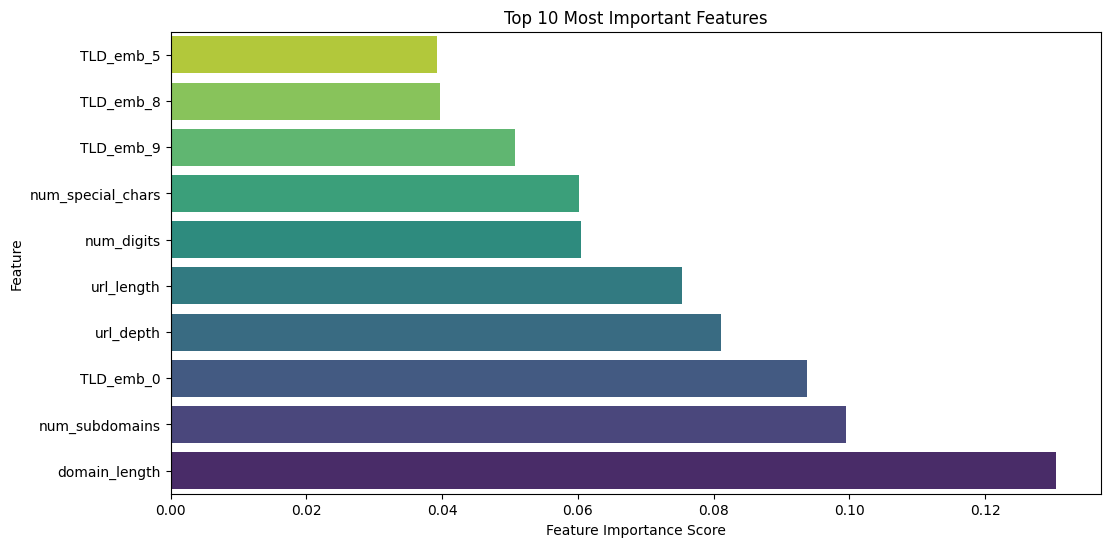

In [84]:
plt.figure(figsize=(12, 6))
sns.barplot(x=importance_df["Importance"][:10], y=importance_df["Feature"][:10], palette="viridis")
plt.xlabel("Feature Importance Score")
plt.ylabel("Feature")
plt.title("Top 10 Most Important Features")
plt.gca().invert_yaxis()  # Invert y-axis to show the highest importance on top
plt.show()

## XGB

In [ ]:
rf = RandomForestClassifier(n_estimators=100, random_state=42)
rf.fit(X_resampled, y_resampled)

# Get feature importances
importances = rf.feature_importances_
feature_names = [f'Feature {i}' for i in range(X_resampled.shape[1])]

# Sort by importance
feature_importance_df = pd.DataFrame({'Feature': feature_names, 'Importance': importances})
feature_importance_df = feature_importance_df.sort_values(by='Importance', ascending=False)

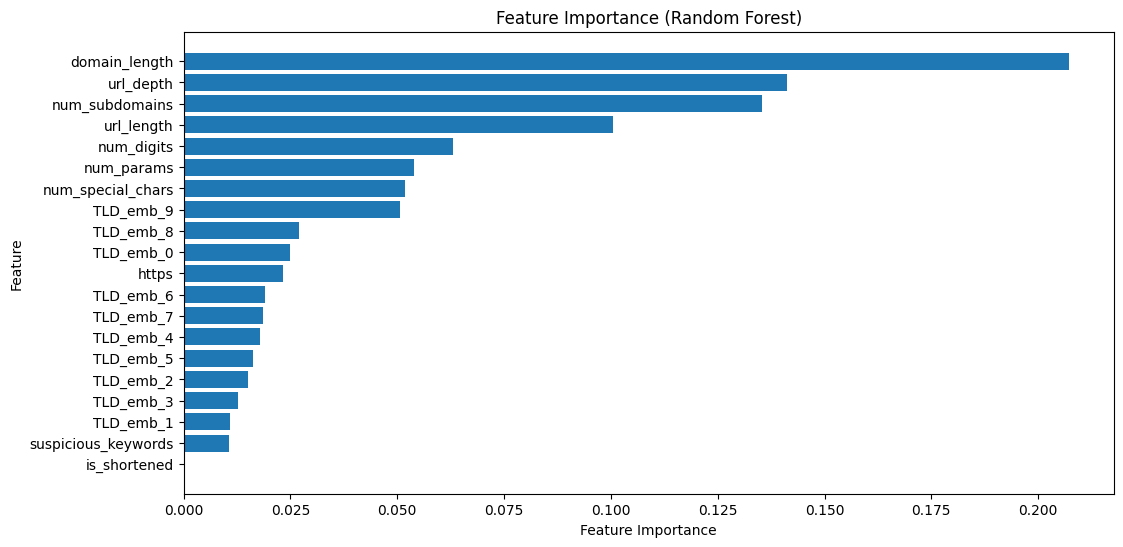

In [44]:
plt.figure(figsize=(12, 6))
sns.barplot(x=feature_importance_df['Importance'][:20], y=feature_importance_df['Feature'][:20], palette='viridis')
plt.xlabel("Importance Score")
plt.ylabel("Feature")
plt.title("Top 20 Most Important Features (Random Forest)")
plt.show()

## RFE

In [ ]:
rf = RandomForestClassifier(n_estimators=100, random_state=42)

rfe = RFE(estimator=rf, n_features_to_select=10)
rfe.fit(X_resampled, y_resampled)

selected_features = X_resampled.columns[rfe.support_]
print("Selected Features:", selected_features)

# Machine Learning

## XGB CLASSIFIER

In [17]:
from sklearn.preprocessing import StandardScaler


X_resampled_df = pd.DataFrame(X_resampled, columns=all_feature_names)  
X_selected = X_resampled_df[top_features]
X_train, X_test, y_train, y_test = train_test_split(X_selected, y_resampled, test_size=0.2, random_state=42)

scaler = StandardScaler()
X_train_scaled = scaler.fit_transform(X_train)
X_test_scaled = scaler.transform(X_test)

In [92]:
xgb = XGBClassifier(use_label_encoder=False, eval_metric='mlogloss', random_state=42)
xgb.fit(X_train, y_train)
y_pred_xgb = xgb.predict(X_test)
print("XGBoost Accuracy:", accuracy_score(y_test, y_pred_xgb))
print(classification_report(y_test, y_pred_xgb))

XGBoost Accuracy: 0.9200219585124276
              precision    recall  f1-score   support

           0       0.86      0.89      0.87     85547
           1       0.94      0.97      0.96     85538
           2       0.97      0.93      0.95     85712
           3       0.83      0.80      0.82     86002
           4       1.00      1.00      1.00     85281

    accuracy                           0.92    428080
   macro avg       0.92      0.92      0.92    428080
weighted avg       0.92      0.92      0.92    428080



## Random Forest

In [93]:
rf = RandomForestClassifier(n_estimators=100, random_state=42)
rf.fit(X_train, y_train)
y_pred_rf = rf.predict(X_test)
print("Random Forest Accuracy:", accuracy_score(y_test, y_pred_rf))
print(classification_report(y_test, y_pred_rf))

Random Forest Accuracy: 0.949154363670342
              precision    recall  f1-score   support

           0       0.90      0.89      0.89     85547
           1       0.99      0.99      0.99     85538
           2       0.99      0.98      0.99     85712
           3       0.87      0.88      0.88     86002
           4       1.00      1.00      1.00     85281

    accuracy                           0.95    428080
   macro avg       0.95      0.95      0.95    428080
weighted avg       0.95      0.95      0.95    428080



## SVM

In [ ]:
svm = SVC(kernel='rbf', probability=True, random_state=42)
svm.fit(X_train_scaled, y_train)  # Use scaled data for SVM

print("SVM Accuracy:", accuracy_score(y_test, y_pred_svm))
print(classification_report(y_test, y_pred_svm))

## Visualizing Results

# Deep Learning Models

In [24]:
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

# Move input tensors to GPU
X_train_tensor = torch.tensor(X_train.values, dtype=torch.float32).to(device)
X_test_tensor = torch.tensor(X_test.values, dtype=torch.float32).to(device)
y_train_tensor = torch.tensor(y_train.values, dtype=torch.long).to(device)
y_test_tensor = torch.tensor(y_test.values, dtype=torch.long).to(device)

train_dataset = TensorDataset(X_train_tensor, y_train_tensor)
test_dataset = TensorDataset(X_test_tensor, y_test_tensor)

# DataLoader remains the same
train_loader = DataLoader(train_dataset, batch_size=64, shuffle=True)
test_loader = DataLoader(test_dataset, batch_size=64, shuffle=False)

In [19]:
class DeepMLP(nn.Module):
    def __init__(self, input_size, num_classes):
        super(DeepMLP, self).__init__()
        self.fc1 = nn.Linear(input_size, 128)
        self.bn1 = nn.BatchNorm1d(128)
        self.fc2 = nn.Linear(128, 256)
        self.bn2 = nn.BatchNorm1d(256)
        self.fc3 = nn.Linear(256, 128)
        self.bn3 = nn.BatchNorm1d(128)
        self.fc4 = nn.Linear(128, num_classes)
        self.dropout = nn.Dropout(0.3)
    
    def forward(self, x):
        x = F.relu(self.bn1(self.fc1(x)))
        x = self.dropout(x)
        x = F.relu(self.bn2(self.fc2(x)))
        x = self.dropout(x)
        x = F.relu(self.bn3(self.fc3(x)))
        x = self.dropout(x)
        x = self.fc4(x)  
        return x

In [20]:
input_size = X_train.shape[1]
num_classes = len(np.unique(y))
model = DeepMLP(input_size, num_classes).to('cuda')

In [21]:
criterion = nn.CrossEntropyLoss()
optimizer = optim.Adam(model.parameters(), lr=2e-4)

num_epochs = 20
train_acc_list, test_acc_list = [], []

In [22]:
def compute_accuracy(loader, model):
    correct, total = 0, 0
    model.eval()
    with torch.no_grad():
        for inputs, labels in loader:
            outputs = model(inputs)
            _, predicted = torch.max(outputs, 1)
            total += labels.size(0)
            correct += (predicted == labels).sum().item()
    return correct / total

In [32]:
for epoch in range(num_epochs):
    model.train()
    for inputs, labels in train_loader:
        optimizer.zero_grad()
        outputs = model(inputs)
        loss = criterion(outputs, labels)
        loss.backward()
        optimizer.step()
    
    # Compute train & test accuracy
    train_acc = compute_accuracy(train_loader, model)
    test_acc = compute_accuracy(test_loader, model)
    train_acc_list.append(train_acc)
    test_acc_list.append(test_acc)
    
    print(f"Epoch {epoch+1}/{num_epochs}, Train Acc: {train_acc:.4f}, Test Acc: {test_acc:.4f}")

Epoch 1/20, Train Acc: 0.8756, Test Acc: 0.8753 
Epoch 2/20, Train Acc: 0.8808, Test Acc: 0.8803 
Epoch 3/20, Train Acc: 0.8871, Test Acc: 0.8870 
Epoch 4/20, Train Acc: 0.8910, Test Acc: 0.8910 
Epoch 5/20, Train Acc: 0.8895, Test Acc: 0.8895 
Epoch 6/20, Train Acc: 0.8955, Test Acc: 0.8959 
Epoch 7/20, Train Acc: 0.8967, Test Acc: 0.8968 
Epoch 8/20, Train Acc: 0.8992, Test Acc: 0.8994 
Epoch 9/20, Train Acc: 0.8975, Test Acc: 0.8977 
Epoch 10/20, Train Acc: 0.8988, Test Acc: 0.8989 
Epoch 11/20, Train Acc: 0.8978, Test Acc: 0.8977 
Epoch 12/20, Train Acc: 0.9013, Test Acc: 0.9013 
Epoch 13/20, Train Acc: 0.8989, Test Acc: 0.8992 
Epoch 14/20, Train Acc: 0.9006, Test Acc: 0.9007 
Epoch 15/20, Train Acc: 0.8978, Test Acc: 0.8978 
Epoch 16/20, Train Acc: 0.9014, Test Acc: 0.9014 
Epoch 17/20, Train Acc: 0.9025, Test Acc: 0.9023 
Epoch 18/20, Train Acc: 0.9007, Test Acc: 0.9010 
Epoch 19/20, Train Acc: 0.9046, Test Acc: 0.9044 
Epoch 20/20, Train Acc: 0.9010, Test Acc: 0.9010


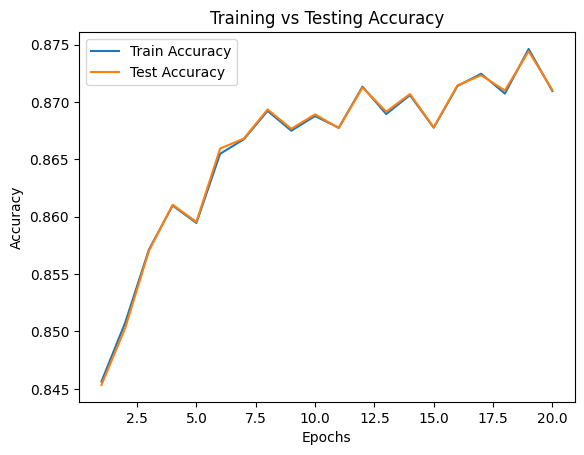

In [33]:
num_epochs = 20
plt.plot(range(1, num_epochs+1), train_acc_list, label='Train Accuracy')
plt.plot(range(1, num_epochs+1), test_acc_list, label='Test Accuracy')
plt.xlabel('Epochs')
plt.ylabel('Accuracy')
plt.legend()
plt.title('Training vs Testing Accuracy')
plt.show()

## TabTransformer

In [41]:
!pip install pytorch-tabular rtdl

INFO: pip is looking at multiple versions of pytorch-lightning to determine which version is compatible with other requirements. This could take a while.
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 802.3/802.3 kB 13.9 MB/s eta 0:00:00a 0:00:01
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 887.5/887.5 MB 1.8 MB/s eta 0:00:000:00:0100:01
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 317.1/317.1 MB 2.3 MB/s eta 0:00:000:00:0100:01
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 21.0/21.0 MB 69.6 MB/s eta 0:00:00:00:0100:01
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 849.3/849.3 kB 42.6 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 557.1/557.1 MB 3.0 MB/s eta 0:00:000:00:0100:01
  Attempting uninstall: torch
    Found existing installation: torch 2.5.1+cu121
    Uninstalling torch-2.5.1+cu121:
      Successfully uninstalled torch-2.5.1+cu121
  Attempting uninstall: pytorch-lightning
    Found existing installation: pytorch-lightning 2.4.0
    Uninstalling pytorch-lightning-2.4.0:
  

In [ ]:
import rtdl  # FT-Transformer library
model = rtdl.FTTransformer.make_default(
    n_num_features=X_train.shape[1],  # Number of numerical features
    cat_cardinalities=None,  # No categorical features
    d_out=5  
).to(device)

criterion = nn.CrossEntropyLoss()
optimizer = optim.AdamW(model.parameters(), lr=1e-3)

# Training loop
num_epochs = 20
for epoch in range(num_epochs):
    model.train()
    optimizer.zero_grad()
    
    # Forward pass with numerical features and None for categorical features
    outputs = model(X_train_tensor, None)
    loss = criterion(outputs, y_train_tensor)
    
    loss.backward()
    optimizer.step()

    # Evaluate on test data
    model.eval()
    with torch.no_grad():
        train_acc = (outputs.argmax(1) == y_train_tensor).float().mean().item()
        test_outputs = model(X_test_tensor, None)  # Pass None for categorical features
        test_acc = (test_outputs.argmax(1) == y_test_tensor).float().mean().item()

    print(f"Epoch {epoch+1}/{num_epochs}, Train Acc: {train_acc:.4f}, Test Acc: {test_acc:.4f}")

/usr/local/lib/python3.10/dist-packages/pytorch_tabnet/abstract_model.py:82: UserWarning: Device used : cuda
  warnings.warn(f"Device used : {self.device}")


epoch 0  | loss: 0.47222 | validation_accuracy: 0.84099 |  0:01:13s
epoch 1  | loss: 0.38685 | validation_accuracy: 0.86058 |  0:02:26s
epoch 2  | loss: 0.35747 | validation_accuracy: 0.85809 |  0:03:40s
epoch 3  | loss: 0.34498 | validation_accuracy: 0.86585 |  0:04:53s
epoch 4  | loss: 0.33928 | validation_accuracy: 0.87205 |  0:06:06s
epoch 5  | loss: 0.33428 | validation_accuracy: 0.87136 |  0:07:19s
epoch 6  | loss: 0.32685 | validation_accuracy: 0.86841 |  0:08:31s
epoch 7  | loss: 0.32236 | validation_accuracy: 0.87927 |  0:09:45s
epoch 8  | loss: 0.31938 | validation_accuracy: 0.87688 |  0:10:57s
epoch 9  | loss: 0.31893 | validation_accuracy: 0.87816 |  0:12:10s
epoch 10 | loss: 0.31575 | validation_accuracy: 0.87779 |  0:13:22s
epoch 11 | loss: 0.31573 | validation_accuracy: 0.87057 |  0:14:35s
epoch 12 | loss: 0.31537 | validation_accuracy: 0.87945 |  0:15:47s
epoch 13 | loss: 0.31175 | validation_accuracy: 0.88124 |  0:16:58s
epoch 14 | loss: 0.31151 | validation_accuracy: 